In [1]:
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

api_key_id = ''
api_secret_key = ''
base_url = 'https://paper-api.alpaca.markets'

# Initialize the REST API connection
api = tradeapi.REST(api_key_id, api_secret_key, base_url, api_version='v2')



In [6]:
def get_historical_data(symbol, start_date, end_date, timeframe='day'):
    barset = api.get_bars(symbol, tradeapi.rest.TimeFrame.Day, start=start_date, end=end_date).df
    return barset


In [7]:
symbols = ['AAPL', 'MSFT', 'GOOGL']  # Example symbols
start_date = '2023-01-01'
end_date = '2024-01-01'

historical_data = {}
for symbol in symbols:
    historical_data[symbol] = get_historical_data(symbol, start_date, end_date)


In [8]:
def calculate_momentum(df, lookback_period=20):
    df['momentum'] = df['close'].pct_change(periods=lookback_period)
    return df


In [9]:
lookback_period = 20  # Example lookback period
for symbol in symbols:
    historical_data[symbol] = calculate_momentum(historical_data[symbol], lookback_period)


C:\Users\mohit\AppData\Local\Temp\ipykernel_5784\3361415093.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.010314224034540631' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[date, 'returns'] = daily_return / top_n if positions else 0


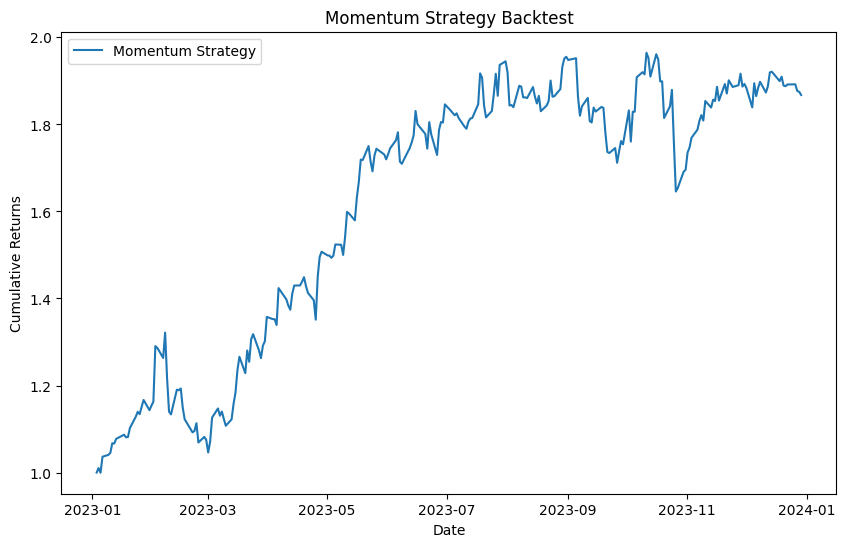

In [15]:
def backtest_momentum_strategy(historical_data, lookback_period=20, top_n=1, holding_period=10):
    portfolio = pd.DataFrame(index=historical_data[symbols[0]].index)
    portfolio['returns'] = 0
    positions = {}

    for date in portfolio.index:
        if date not in portfolio.index:  # Skip if date is not a trading day
            continue
        previous_date = portfolio.index[portfolio.index.get_loc(date) - 1] if portfolio.index.get_loc(date) > 0 else None
        if not previous_date:
            continue

        # Check for sell signals (end of holding period or negative momentum)
        for symbol in list(positions.keys()):
            entry_date, _ = positions[symbol]
            if (date - entry_date).days >= holding_period:
                # Sell the position
                positions.pop(symbol)

        # Get momentum scores for all symbols on the current date
        momentum_scores = {symbol: historical_data[symbol].loc[date]['momentum'] for symbol in symbols if date in historical_data[symbol].index}
        sorted_momentum = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        top_symbols = [x[0] for x in sorted_momentum[:top_n]]

        # Check for buy signals (top N momentum scores)
        for symbol in top_symbols:
            if symbol not in positions and previous_date in historical_data[symbol].index:
                # Buy the position
                positions[symbol] = (date, historical_data[symbol].loc[date]['close'])

        # Calculate daily returns
        daily_return = 0
        for symbol, (entry_date, entry_price) in positions.items():
            if previous_date in historical_data[symbol].index:
                daily_return += historical_data[symbol].loc[date]['close'] / historical_data[symbol].loc[previous_date]['close'] - 1
        portfolio.loc[date, 'returns'] = daily_return / top_n if positions else 0

    portfolio['cumulative_returns'] = (1 + portfolio['returns']).cumprod()
    return portfolio

portfolio = backtest_momentum_strategy(historical_data, lookback_period, top_n=1, holding_period=10)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['cumulative_returns'], label='Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Momentum Strategy Backtest')
plt.legend()
plt.show()


In [16]:
import numpy as np

def calculate_performance_metrics(portfolio):
    # Calculate cumulative returns
    cumulative_returns = portfolio['cumulative_returns'].iloc[-1] - 1

    # Calculate annualized return
    trading_days = 252  # Approximate number of trading days in a year
    annualized_return = (1 + cumulative_returns) ** (trading_days / len(portfolio)) - 1

    # Calculate annualized volatility
    annualized_volatility = portfolio['returns'].std() * np.sqrt(trading_days)

    # Calculate Sharpe ratio
    risk_free_rate = 0.01  # Example risk-free rate
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate maximum drawdown
    cumulative_returns_series = portfolio['cumulative_returns']
    drawdown = cumulative_returns_series / cumulative_returns_series.cummax() - 1
    max_drawdown = drawdown.min()

    return {
        'Cumulative Returns': cumulative_returns,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate metrics for the portfolio
metrics = calculate_performance_metrics(portfolio)
def display_metrics(metrics):
    print("Performance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")

display_metrics(metrics)


Performance Metrics:
Cumulative Returns: 0.87
Annualized Return: 0.88
Annualized Volatility: 0.36
Sharpe Ratio: 2.42
Max Drawdown: -0.21


### S&P 500

In [25]:
# Fetch S&P 500 Constituents
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
sp500 = tables[0]
symbols = sp500['Symbol'].tolist()

def get_historical_data(symbols, start_date, end_date):
    data = {}
    valid_symbols = []
    for symbol in symbols:
        try:
            barset = api.get_bars(symbol, tradeapi.rest.TimeFrame.Day, start=start_date, end=end_date).df
            if not barset.empty:
                barset.index = pd.to_datetime(barset.index).tz_localize(None)  # Remove timezone information for simplicity
                data[symbol] = barset
                valid_symbols.append(symbol)
        except Exception as e:
            print(f"Could not fetch data for {symbol}: {e}")
    return data, valid_symbols

start_date = '2023-01-01'
end_date = '2024-01-01'
historical_data, valid_symbols = get_historical_data(symbols, start_date, end_date)



In [26]:
def calculate_momentum(df, lookback_period=20):
    df['momentum'] = df['close'].pct_change(periods=lookback_period)
    return df

lookback_period = 20  # Example lookback period
for symbol in valid_symbols:
    historical_data[symbol] = calculate_momentum(historical_data[symbol], lookback_period)


C:\Users\mohit\AppData\Local\Temp\ipykernel_5784\3397476521.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.006861531640210611' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[date, 'returns'] = daily_return / starting_capital if positions else 0


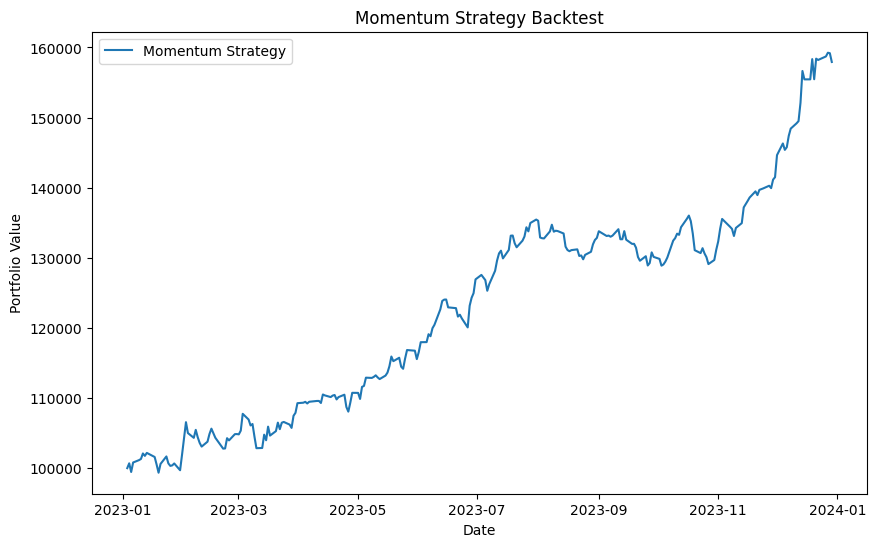

In [39]:
def backtest_momentum_strategy(historical_data, valid_symbols, lookback_period=20, top_n=10, holding_period=20, starting_capital=100000):
    portfolio = pd.DataFrame(index=historical_data[valid_symbols[0]].index)
    portfolio['returns'] = 0
    positions = {}
    capital = starting_capital
    cash = starting_capital

    for date in portfolio.index:
        if date not in portfolio.index:  # Skip if date is not a trading day
            continue
        previous_date = portfolio.index[portfolio.index.get_loc(date) - 1] if portfolio.index.get_loc(date) > 0 else None
        if not previous_date:
            continue

        # Check for sell signals (end of holding period)
        for symbol in list(positions.keys()):
            entry_date, entry_price, shares = positions[symbol]
            if (date - entry_date).days >= holding_period:
                # Sell the position
                sell_price = historical_data[symbol].loc[date]['close']
                cash += shares * sell_price
                positions.pop(symbol)

        # Get momentum scores for all valid symbols on the current date
        momentum_scores = {symbol: historical_data[symbol].loc[date]['momentum'] for symbol in valid_symbols if date in historical_data[symbol].index}
        sorted_momentum = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        top_symbols = [x[0] for x in sorted_momentum[:top_n]]

        # Check for buy signals (top N momentum scores)
        for symbol in top_symbols:
            if symbol not in positions and previous_date in historical_data[symbol].index:
                # Buy the position
                buy_price = historical_data[symbol].loc[date]['close']
                shares = (cash / top_n) // buy_price
                cash -= shares * buy_price
                positions[symbol] = (date, buy_price, shares)

        # Calculate daily returns
        daily_return = 0
        for symbol, (entry_date, entry_price, shares) in positions.items():
            if previous_date in historical_data[symbol].index:
                daily_return += (historical_data[symbol].loc[date]['close'] / historical_data[symbol].loc[previous_date]['close'] - 1) * shares * entry_price
        portfolio.loc[date, 'returns'] = daily_return / starting_capital if positions else 0

    portfolio['cumulative_returns'] = (1 + portfolio['returns']).cumprod() * starting_capital
    return portfolio

starting_capital = 100000
portfolio = backtest_momentum_strategy(historical_data, valid_symbols, lookback_period, top_n=10, holding_period=20, starting_capital=starting_capital)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['cumulative_returns'], label='Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Momentum Strategy Backtest')
plt.legend()
plt.show()

In [37]:
portfolio

,returns,cumulative_returns
timestamp,,
2023-01-03 05:00:00,0.000000,100000.000000
2023-01-04 05:00:00,0.006862,100686.153164
2023-01-05 05:00:00,-0.012287,99448.992194
2023-01-06 05:00:00,0.013622,100803.665386
2023-01-09 05:00:00,0.003354,101141.743142
...,...,...
2023-12-22 05:00:00,-0.001180,158211.227406
2023-12-26 05:00:00,0.003173,158713.161858
2023-12-27 05:00:00,0.003350,159244.841402


In [38]:
import numpy as np

def calculate_performance_metrics(portfolio, starting_capital):
    # Calculate cumulative returns
    cumulative_returns = (portfolio['cumulative_returns'].iloc[-1] / starting_capital) - 1

    # Calculate annualized return
    trading_days = 252  # Approximate number of trading days in a year
    annualized_return = (portfolio['cumulative_returns'].iloc[-1] / starting_capital) ** (trading_days / len(portfolio)) - 1

    # Calculate annualized volatility
    annualized_volatility = portfolio['returns'].std() * np.sqrt(trading_days)

    # Calculate Sharpe ratio
    risk_free_rate = 0.01  # Example risk-free rate
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate maximum drawdown
    cumulative_returns_series = portfolio['cumulative_returns']
    drawdown = cumulative_returns_series / cumulative_returns_series.cummax() - 1
    max_drawdown = drawdown.min()

    return {
        'Cumulative Returns': cumulative_returns,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate metrics for the portfolio
metrics = calculate_performance_metrics(portfolio, starting_capital)

def display_metrics(metrics):
    print("Performance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")

display_metrics(metrics)


Performance Metrics:
Cumulative Returns: 0.58
Annualized Return: 0.59
Annualized Volatility: 0.14
Sharpe Ratio: 4.11
Max Drawdown: -0.05


### Mid-Cap

In [42]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_400_companies'

# Read the tables on the Wikipedia page
tables = pd.read_html(url)

# The table we want is the first one (S&P 400 MidCap Index)
mid_cap_table = tables[0]

# Extract the symbols
mid_cap_symbols = mid_cap_table['Symbol'].tolist()

# Display the list of mid-cap symbols
print(mid_cap_symbols)

['AA', 'AAON', 'ACHC', 'ACM', 'ADC', 'ADNT', 'AFG', 'AGCO', 'AIRC', 'AIT', 'ALE', 'ALGM', 'ALLY', 'ALTM', 'ALV', 'AM', 'AMED', 'AMG', 'AMH', 'AMKR', 'AN', 'APPF', 'AR', 'ARMK', 'ARW', 'ARWR', 'ASB', 'ASGN', 'ASH', 'ATR', 'AVNT', 'AVT', 'AXTA', 'AYI', 'AZPN', 'AZTA', 'BC', 'BCO', 'BDC', 'BERY', 'BHF', 'BJ', 'BKH', 'BLD', 'BLKB', 'BRBR', 'BRKR', 'BRX', 'BURL', 'BWXT', 'BYD', 'CACI', 'CADE', 'CAR', 'CASY', 'CBSH', 'CBT', 'CC', 'CCK', 'CDP', 'CELH', 'CFR', 'CG', 'CGNX', 'CHDN', 'CHE', 'CHH', 'CHK', 'CHRD', 'CHX', 'CIEN', 'CIVI', 'CLF', 'CLH', 'CMC', 'CNM', 'CNO', 'CNX', 'CNXC', 'COHR', 'COKE', 'COLB', 'COLM', 'COTY', 'CPRI', 'CR', 'CRI', 'CROX', 'CRUS', 'CSL', 'CUBE', 'CUZ', 'CVLT', 'CW', 'CXT', 'CYTK', 'DAR', 'DBX', 'DCI', 'DINO', 'DKS', 'DLB', 'DOCS', 'DT', 'DTM', 'DUOL', 'EEFT', 'EGP', 'EHC', 'ELF', 'ELS', 'EME', 'ENOV', 'ENS', 'EPR', 'EQH', 'ERIE', 'ESAB', 'ESNT', 'ETRN', 'EVR', 'EWBC', 'EXEL', 'EXLS', 'EXP', 'EXPO', 'FAF', 'FBIN', 'FCFS', 'FCN', 'FFIN', 'FHI', 'FHN', 'FIVE', 'FIX', 'F

In [43]:

def get_historical_data(symbols, start_date, end_date):
    data = {}
    valid_symbols = []
    for symbol in symbols:
        try:
            barset = api.get_bars(symbol, tradeapi.rest.TimeFrame.Day, start=start_date, end=end_date).df
            if not barset.empty:
                barset.index = pd.to_datetime(barset.index).tz_localize(None)  # Remove timezone information for simplicity
                data[symbol] = barset
                valid_symbols.append(symbol)
        except Exception as e:
            print(f"Could not fetch data for {symbol}: {e}")
    return data, valid_symbols

start_date = '2023-01-01'
end_date = '2024-01-01'
historical_data, valid_symbols = get_historical_data(mid_cap_symbols, start_date, end_date)



C:\Users\mohit\AppData\Local\Temp\ipykernel_5784\3415626699.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0043018072669726475' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[date, 'returns'] = daily_return / starting_capital if positions else 0


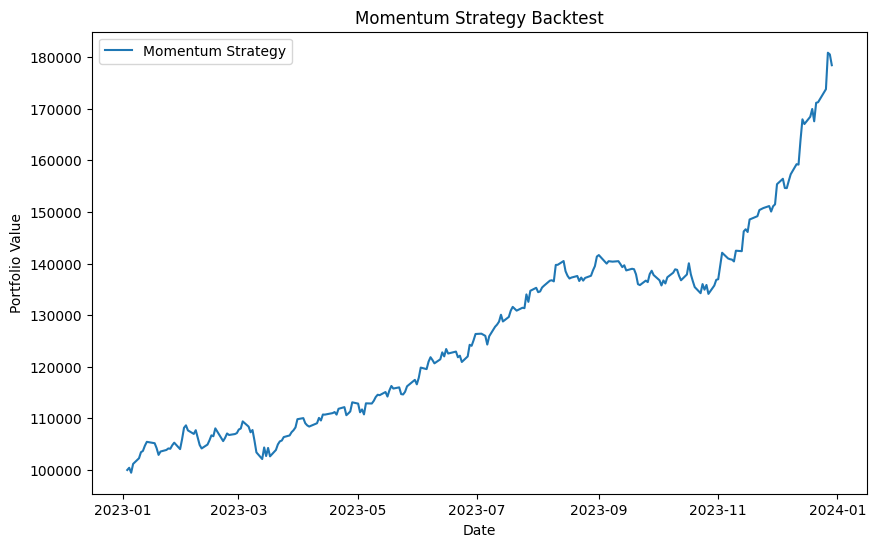

In [44]:
def calculate_momentum(df, lookback_period=20):
    df['momentum'] = df['close'].pct_change(periods=lookback_period)
    return df

lookback_period = 20  # Example lookback period
for symbol in valid_symbols:
    historical_data[symbol] = calculate_momentum(historical_data[symbol], lookback_period)


def backtest_momentum_strategy(historical_data, valid_symbols, lookback_period=20, top_n=10, holding_period=20, starting_capital=100000):
    portfolio = pd.DataFrame(index=historical_data[valid_symbols[0]].index)
    portfolio['returns'] = 0
    positions = {}
    capital = starting_capital
    cash = starting_capital

    for date in portfolio.index:
        if date not in portfolio.index:  # Skip if date is not a trading day
            continue
        previous_date = portfolio.index[portfolio.index.get_loc(date) - 1] if portfolio.index.get_loc(date) > 0 else None
        if not previous_date:
            continue

        # Check for sell signals (end of holding period)
        for symbol in list(positions.keys()):
            entry_date, entry_price, shares = positions[symbol]
            if (date - entry_date).days >= holding_period:
                # Sell the position
                sell_price = historical_data[symbol].loc[date]['close']
                cash += shares * sell_price
                positions.pop(symbol)

        # Get momentum scores for all valid symbols on the current date
        momentum_scores = {symbol: historical_data[symbol].loc[date]['momentum'] for symbol in valid_symbols if date in historical_data[symbol].index}
        sorted_momentum = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        top_symbols = [x[0] for x in sorted_momentum[:top_n]]

        # Check for buy signals (top N momentum scores)
        for symbol in top_symbols:
            if symbol not in positions and previous_date in historical_data[symbol].index:
                # Buy the position
                buy_price = historical_data[symbol].loc[date]['close']
                shares = (cash / top_n) // buy_price
                cash -= shares * buy_price
                positions[symbol] = (date, buy_price, shares)

        # Calculate daily returns
        daily_return = 0
        for symbol, (entry_date, entry_price, shares) in positions.items():
            if previous_date in historical_data[symbol].index:
                daily_return += (historical_data[symbol].loc[date]['close'] / historical_data[symbol].loc[previous_date]['close'] - 1) * shares * entry_price
        portfolio.loc[date, 'returns'] = daily_return / starting_capital if positions else 0

    portfolio['cumulative_returns'] = (1 + portfolio['returns']).cumprod() * starting_capital
    return portfolio

starting_capital = 100000
portfolio = backtest_momentum_strategy(historical_data, valid_symbols, lookback_period, top_n=10, holding_period=20, starting_capital=starting_capital)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['cumulative_returns'], label='Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Momentum Strategy Backtest')
plt.legend()
plt.show()

In [45]:
import numpy as np

def calculate_performance_metrics(portfolio, starting_capital):
    # Calculate cumulative returns
    cumulative_returns = (portfolio['cumulative_returns'].iloc[-1] / starting_capital) - 1

    # Calculate annualized return
    trading_days = 252  # Approximate number of trading days in a year
    annualized_return = (portfolio['cumulative_returns'].iloc[-1] / starting_capital) ** (trading_days / len(portfolio)) - 1

    # Calculate annualized volatility
    annualized_volatility = portfolio['returns'].std() * np.sqrt(trading_days)

    # Calculate Sharpe ratio
    risk_free_rate = 0.01  # Example risk-free rate
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate maximum drawdown
    cumulative_returns_series = portfolio['cumulative_returns']
    drawdown = cumulative_returns_series / cumulative_returns_series.cummax() - 1
    max_drawdown = drawdown.min()

    return {
        'Cumulative Returns': cumulative_returns,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate metrics for the portfolio
metrics = calculate_performance_metrics(portfolio, starting_capital)

def display_metrics(metrics):
    print("Performance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")

display_metrics(metrics)


Performance Metrics:
Cumulative Returns: 0.78
Annualized Return: 0.79
Annualized Volatility: 0.15
Sharpe Ratio: 5.10
Max Drawdown: -0.07


In [48]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_600_companies'

# Read the tables on the Wikipedia page
tables = pd.read_html(url)

# The table we want is the first one (S&P 400 MidCap Index)
small_cap_table = tables[0]

# Extract the symbols
small_cap_symbols = small_cap_table['Symbol'].tolist()

# Display the list of mid-cap symbols
print(small_cap_symbols)

['AAP', 'AAT', 'ABCB', 'ABG', 'ABM', 'ABR', 'ACA', 'ACIW', 'ACLS', 'ADEA', 'ADTN', 'ADUS', 'AEIS', 'AEO', 'AGO', 'AGYS', 'AHCO', 'AHH', 'AIN', 'AIR', 'AKR', 'AL', 'ALEX', 'ALG', 'ALGT', 'ALK', 'ALKS', 'ALRM', 'AMBC', 'AMCX', 'AMN', 'AMPH', 'AMR', 'AMSF', 'AMWD', 'ANDE', 'ANF', 'ANIP', 'AORT', 'AOSL', 'APAM', 'APLE', 'APOG', 'ARCB', 'ARCH', 'ARI', 'ARLO', 'AROC', 'ARR', 'ASIX', 'ASO', 'ASTE', 'ASTH', 'ATEN', 'ATGE', 'ATI', 'ATNI', 'AUB', 'AVA', 'AVAV', 'AVNS', 'AWI', 'AWR', 'AX', 'AXL', 'AZZ', 'B', 'BANC', 'BANF', 'BANR', 'BCC', 'BCPC', 'BDN', 'BFH', 'BFS', 'BGC', 'BGS', 'BHE', 'BHLB', 'BJRI', 'BKE', 'BKU', 'BL', 'BLFS', 'BLMN', 'BMI', 'BOH', 'BOOT', 'BOX', 'BRC', 'BRKL', 'BSIG', 'BTU', 'BXMT', 'CABO', 'CAKE', 'CAL', 'CALM', 'CALX', 'CARG', 'CARS', 'CASH', 'CATY', 'CBRL', 'CBU', 'CCOI', 'CCRN', 'CCS', 'CEIX', 'CENT', 'CENTA', 'CENX', 'CERT', 'CEVA', 'CFFN', 'CHCO', 'CHCT', 'CHEF', 'CHUY', 'CLB', 'CLDT', 'CLW', 'CMP', 'CNK', 'CNMD', 'CNS', 'CNSL', 'CNXN', 'COHU', 'COLL', 'COOP', 'CORT', 

In [50]:

def get_historical_data(symbols, start_date, end_date):
    data = {}
    valid_symbols = []
    for symbol in symbols:
        try:
            barset = api.get_bars(symbol, tradeapi.rest.TimeFrame.Day, start=start_date, end=end_date).df
            if not barset.empty:
                barset.index = pd.to_datetime(barset.index).tz_localize(None)  # Remove timezone information for simplicity
                data[symbol] = barset
                valid_symbols.append(symbol)
        except Exception as e:
            print(f"Could not fetch data for {symbol}: {e}")
    return data, valid_symbols

start_date = '2023-01-01'
end_date = '2024-01-01'
historical_data, valid_symbols = get_historical_data(small_cap_symbols, start_date, end_date)



C:\Users\mohit\AppData\Local\Temp\ipykernel_5784\3415626699.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.011901266238570966' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[date, 'returns'] = daily_return / starting_capital if positions else 0


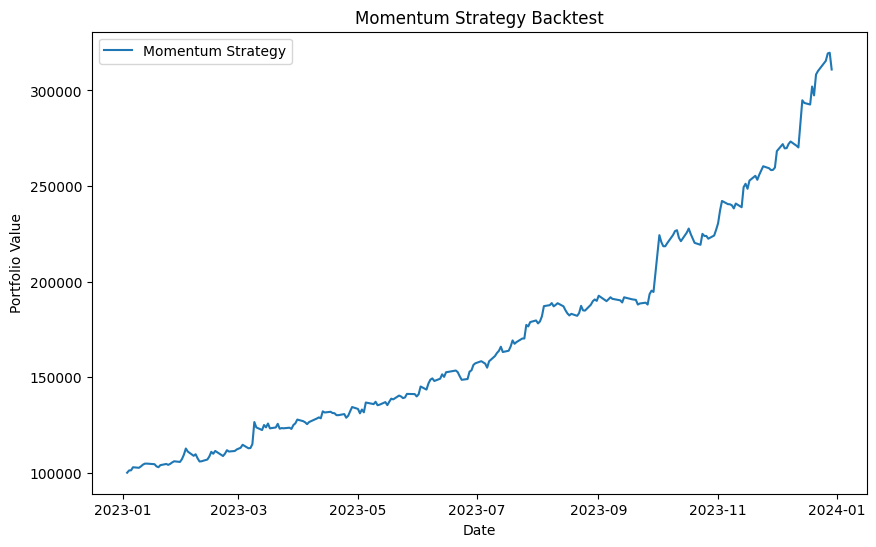

In [175]:
def calculate_momentum(df, lookback_period=20):
    df['momentum'] = df['close'].pct_change(periods=lookback_period)
    return df

lookback_period = 20  # Example lookback period
for symbol in valid_symbols:
    historical_data[symbol] = calculate_momentum(historical_data[symbol], lookback_period)


def backtest_momentum_strategy(historical_data, valid_symbols, lookback_period=20, top_n=10, holding_period=20, starting_capital=100000):
    portfolio = pd.DataFrame(index=historical_data[valid_symbols[0]].index)
    portfolio['returns'] = 0
    positions = {}
    capital = starting_capital
    cash = starting_capital

    for date in portfolio.index:
        if date not in portfolio.index:  # Skip if date is not a trading day
            continue
        previous_date = portfolio.index[portfolio.index.get_loc(date) - 1] if portfolio.index.get_loc(date) > 0 else None
        if not previous_date:
            continue

        # Check for sell signals (end of holding period)
        for symbol in list(positions.keys()):
            entry_date, entry_price, shares = positions[symbol]
            if (date - entry_date).days >= holding_period:
                # Sell the position
                sell_price = historical_data[symbol].loc[date]['close']
                cash += shares * sell_price
                positions.pop(symbol)

        # Get momentum scores for all valid symbols on the current date
        momentum_scores = {symbol: historical_data[symbol].loc[date]['momentum'] for symbol in valid_symbols if date in historical_data[symbol].index}
        sorted_momentum = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        top_symbols = [x[0] for x in sorted_momentum[:top_n]]

        # Check for buy signals (top N momentum scores)
        for symbol in top_symbols:
            if symbol not in positions and previous_date in historical_data[symbol].index:
                # Buy the position
                buy_price = historical_data[symbol].loc[date]['close']
                shares = (cash / top_n) // buy_price
                cash -= shares * buy_price
                positions[symbol] = (date, buy_price, shares)

        # Calculate daily returns
        daily_return = 0
        for symbol, (entry_date, entry_price, shares) in positions.items():
            if previous_date in historical_data[symbol].index:
                daily_return += (historical_data[symbol].loc[date]['close'] / historical_data[symbol].loc[previous_date]['close'] - 1) * shares * entry_price
        portfolio.loc[date, 'returns'] = daily_return / starting_capital if positions else 0

    portfolio['cumulative_returns'] = (1 + portfolio['returns']).cumprod() * starting_capital
    return portfolio

starting_capital = 100000
portfolio = backtest_momentum_strategy(historical_data, valid_symbols, lookback_period, top_n=10, holding_period=20, starting_capital=starting_capital)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['cumulative_returns'], label='Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Momentum Strategy Backtest')
plt.legend()
plt.show()

In [176]:
import numpy as np

def calculate_performance_metrics(portfolio, starting_capital):
    # Calculate cumulative returns
    cumulative_returns = (portfolio['cumulative_returns'].iloc[-1] / starting_capital) - 1

    # Calculate annualized return
    trading_days = 252  # Approximate number of trading days in a year
    annualized_return = (portfolio['cumulative_returns'].iloc[-1] / starting_capital) ** (trading_days / len(portfolio)) - 1

    # Calculate annualized volatility
    annualized_volatility = portfolio['returns'].std() * np.sqrt(trading_days)

    # Calculate Sharpe ratio
    risk_free_rate = 0.01  # Example risk-free rate
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate maximum drawdown
    cumulative_returns_series = portfolio['cumulative_returns']
    drawdown = cumulative_returns_series / cumulative_returns_series.cummax() - 1
    max_drawdown = drawdown.min()

    return {
        'Cumulative Returns': cumulative_returns,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate metrics for the portfolio
metrics = calculate_performance_metrics(portfolio, starting_capital)

def display_metrics(metrics):
    print("Performance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")

display_metrics(metrics)


Performance Metrics:
Cumulative Returns: 2.11
Annualized Return: 2.14
Annualized Volatility: 0.27
Sharpe Ratio: 7.78
Max Drawdown: -0.06


### Including Economic Factors

In [58]:
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web

# URL of Wikipedia page for S&P 600 SmallCap companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_600_companies'

# Read the tables on the Wikipedia page
tables = pd.read_html(url)

# The table we want is the first one (S&P 600 SmallCap Index)
small_cap_table = tables[0]

# Extract the symbols
small_cap_symbols = small_cap_table['Symbol'].tolist()

# Fetch Economic Data
def get_economic_data():
    start_date = '2022-01-01'
    end_date = '2024-01-01'
    gdp = web.DataReader('GDP', 'fred', start_date, end_date)
    inflation = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
    unemployment = web.DataReader('UNRATE', 'fred', start_date, end_date)
    interest_rate = web.DataReader('DGS10', 'fred', start_date, end_date)
    
    economic_data = pd.concat([gdp, inflation, unemployment, interest_rate], axis=1)
    economic_data.columns = ['GDP', 'Inflation', 'Unemployment', 'Interest Rate']
    economic_data.fillna(method='ffill', inplace=True)
    return economic_data

economic_data = get_economic_data()

def get_historical_data(symbols, start_date, end_date):
    data = {}
    valid_symbols = []
    for symbol in symbols:
        try:
            barset = api.get_bars(symbol, tradeapi.rest.TimeFrame.Day, start=start_date, end=end_date).df
            if not barset.empty:
                barset.index = pd.to_datetime(barset.index).tz_localize(None)  # Remove timezone information for simplicity
                data[symbol] = barset
                valid_symbols.append(symbol)
        except Exception as e:
            print(f"Could not fetch data for {symbol}: {e}")
    return data, valid_symbols

start_date = '2023-01-01'
momentum_end_date = '2024-01-01'
trading_start_date = '2023-01-01'
trading_end_date = '2024-01-01'





C:\Users\mohit\AppData\Local\Temp\ipykernel_5784\2166069671.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  economic_data.fillna(method='ffill', inplace=True)


In [59]:
# Fetch data for momentum calculation
historical_data_momentum, valid_symbols = get_historical_data(small_cap_symbols, start_date, momentum_end_date)

# Fetch data for trading
historical_data_trading = historical_data_momentum



In [93]:
historical_data['AAP']

,close,high,low,trade_count,open,volume,vwap,momentum
timestamp,,,,,,,,
2023-01-03 05:00:00,151.54,151.6599,146.000,30490,146.16,1307388,149.862430,NaN
2023-01-04 05:00:00,151.89,154.5000,150.890,22633,152.73,834211,152.353907,NaN
2023-01-05 05:00:00,153.16,154.4400,149.880,21602,150.45,795895,152.788815,NaN
2023-01-06 05:00:00,154.02,155.7400,153.330,22802,153.67,717897,154.319936,NaN
2023-01-09 05:00:00,152.26,155.1184,152.150,19458,154.03,781431,153.292254,NaN
...,...,...,...,...,...,...,...,...
2023-12-22 05:00:00,61.25,61.9300,60.150,18581,60.15,1174680,61.292150,0.153919
2023-12-26 05:00:00,60.92,61.5700,60.750,17141,61.24,1072419,61.113843,0.194276
2023-12-27 05:00:00,61.56,61.5600,60.900,20768,61.22,1287939,61.234067,0.192099


In [134]:
economic_data.reset_index().dtypes

DATE             datetime64[ns]
GDP                     float64
Inflation               float64
Unemployment            float64
Interest Rate           float64
dtype: object

In [167]:
def merge_data_new(historical_data, economic_data):
    combined_data = {}
    for symbol in historical_data:
        df = historical_data[symbol].copy()
        df = df.reset_index()
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        economic_data['DATE'] = pd.to_datetime(economic_data['DATE'])
        df['timestamp'] = df['timestamp'].dt.normalize()

        # print(df)
        # print(economic_data)
        # break

        df_new = pd.merge(df, economic_data, left_on='timestamp', right_on='DATE', how='left')
        
        df_new.fillna(method='ffill', inplace=True)
        df_new.set_index('DATE', inplace=True)
        combined_data[symbol] = df_new
    
    return combined_data

historical_data_momentum = merge_data_new(historical_data, economic_data)
historical_data_trading = historical_data_momentum


C:\Users\mohit\AppData\Local\Temp\ipykernel_5784\1118460927.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_new.fillna(method='ffill', inplace=True)
C:\Users\mohit\AppData\Local\Temp\ipykernel_5784\1118460927.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_new.fillna(method='ffill', inplace=True)
C:\Users\mohit\AppData\Local\Temp\ipykernel_5784\1118460927.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_new.fillna(method='ffill', inplace=True)
C:\Users\mohit\AppData\Local\Temp\ipykernel_5784\1118460927.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_new.fillna(method='ffill', inplace=True)
C:\U

In [187]:
economic_data = economic_data.set_index('DATE')

In [188]:
economic_data

,GDP,Inflation,Unemployment,Interest Rate
DATE,,,,
2022-01-01,25029.116,282.390,4.0,NaN
2022-01-03,25029.116,282.390,4.0,1.63
2022-01-04,25029.116,282.390,4.0,1.66
2022-01-05,25029.116,282.390,4.0,1.71
2022-01-06,25029.116,282.390,4.0,1.73
...,...,...,...,...
2023-12-26,27956.998,308.742,3.7,3.89
2023-12-27,27956.998,308.742,3.7,3.79
2023-12-28,27956.998,308.742,3.7,3.84


In [227]:
historical_data_momentum['AAP']

,timestamp,close,high,low,trade_count,open,volume,vwap,momentum,GDP,Inflation,Unemployment,Interest Rate
DATE,,,,,,,,,,,,,
2023-01-03,2023-01-03,151.54,151.6599,146.000,30490,146.16,1307388,149.862430,NaN,26813.601,300.356,3.4,3.79
2023-01-04,2023-01-04,151.89,154.5000,150.890,22633,152.73,834211,152.353907,NaN,26813.601,300.356,3.4,3.69
2023-01-05,2023-01-05,153.16,154.4400,149.880,21602,150.45,795895,152.788815,NaN,26813.601,300.356,3.4,3.71
2023-01-06,2023-01-06,154.02,155.7400,153.330,22802,153.67,717897,154.319936,NaN,26813.601,300.356,3.4,3.55
2023-01-09,2023-01-09,152.26,155.1184,152.150,19458,154.03,781431,153.292254,NaN,26813.601,300.356,3.4,3.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,2023-12-22,61.25,61.9300,60.150,18581,60.15,1174680,61.292150,0.153919,27956.998,308.742,3.7,3.90
2023-12-26,2023-12-26,60.92,61.5700,60.750,17141,61.24,1072419,61.113843,0.194276,27956.998,308.742,3.7,3.89
2023-12-27,2023-12-27,61.56,61.5600,60.900,20768,61.22,1287939,61.234067,0.192099,27956.998,308.742,3.7,3.79


In [233]:
def calculate_momentum(df, lookback_period=50, weights=None):
    # Default weights if not provided
    if weights is None:
        weights = {
            'price_momentum': 0.5,
            'GDP': 0.2,
            'Inflation': 0.1,
            'Unemployment': 0.1,
            'Interest Rate': 0.1
        }

    # Calculate price momentum
    df['price_momentum'] = df['close'].pct_change(periods=lookback_period)

    # Normalize the economic variables
    df['GDP_normalized'] = (df['GDP'] - df['GDP'].mean()) / df['GDP'].std()
    df['Inflation_normalized'] = (df['Inflation'] - df['Inflation'].mean()) / df['Inflation'].std()
    df['Unemployment_normalized'] = (df['Unemployment'] - df['Unemployment'].mean()) / df['Unemployment'].std()
    df['Interest Rate_normalized'] = (df['Interest Rate'] - df['Interest Rate'].mean()) / df['Interest Rate'].std()

    # Calculate combined momentum
    df['new_momentum'] = (weights['price_momentum'] * df['price_momentum'] +
                      weights['GDP'] * df['GDP_normalized'] +
                      weights['Inflation'] * df['Inflation_normalized'] +
                      weights['Unemployment'] * df['Unemployment_normalized'] +
                      weights['Interest Rate'] * df['Interest Rate_normalized'])

    # Drop intermediate columns
    df.drop(columns=['price_momentum', 'GDP_normalized', 'Inflation_normalized', 
                     'Unemployment_normalized', 'Interest Rate_normalized'], inplace=True)
    
    return df

lookback_period = 20  # Example lookback period
for symbol in valid_symbols:
    historical_data_momentum[symbol] = calculate_momentum(historical_data_momentum[symbol], lookback_period)
    


C:\Users\mohit\AppData\Local\Temp\ipykernel_5784\848856023.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.011901266238570966' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[date, 'returns'] = daily_return / starting_capital if positions else 0


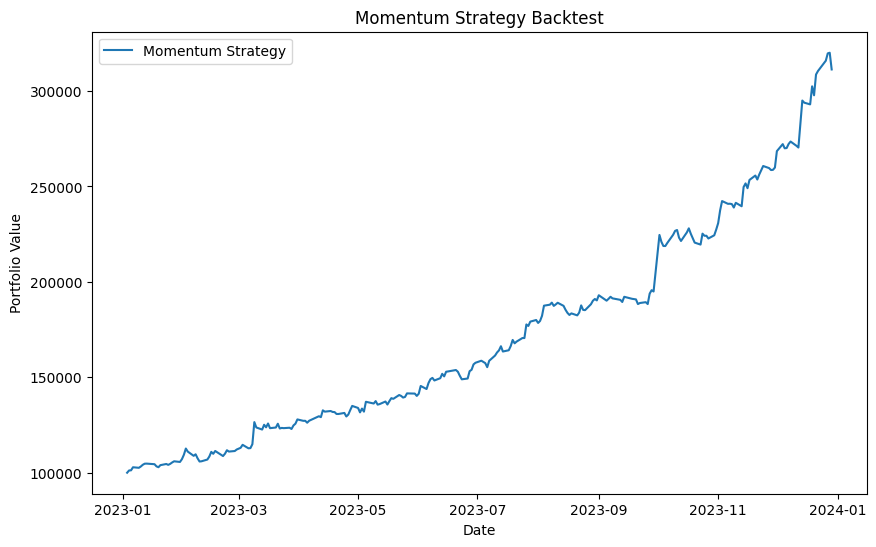

In [234]:
def backtest_momentum_strategy(historical_data_momentum, valid_symbols, lookback_period=20, top_n=10, holding_period=20, starting_capital=100000):
    portfolio = pd.DataFrame(index=historical_data_momentum[valid_symbols[0]].index)
    portfolio['returns'] = 0
    positions = {}
    capital = starting_capital
    cash = starting_capital

    for date in portfolio.index:
        if date not in portfolio.index:  # Skip if date is not a trading day
            continue
        previous_date = portfolio.index[portfolio.index.get_loc(date) - 1] if portfolio.index.get_loc(date) > 0 else None
        if not previous_date:
            continue

        # Check for sell signals (end of holding period)
        for symbol in list(positions.keys()):
            entry_date, entry_price, shares = positions[symbol]
            if (date - entry_date).days >= holding_period:
                # Sell the position
                sell_price = historical_data_momentum[symbol].loc[date]['close']
                cash += shares * sell_price
                positions.pop(symbol)

        # Get momentum scores for all valid symbols on the current date
        momentum_scores = {symbol: historical_data_momentum[symbol].loc[date]['new_momentum'] for symbol in valid_symbols if date in historical_data_momentum[symbol].index}
        sorted_momentum = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        top_symbols = [x[0] for x in sorted_momentum[:top_n]]

        # Check for buy signals (top N momentum scores)
        for symbol in top_symbols:
            if symbol not in positions and previous_date in historical_data_momentum[symbol].index:
                # Buy the position
                buy_price = historical_data_momentum[symbol].loc[date]['close']
                shares = (cash / top_n) // buy_price
                cash -= shares * buy_price
                positions[symbol] = (date, buy_price, shares)

        # Calculate daily returns
        daily_return = 0
        for symbol, (entry_date, entry_price, shares) in positions.items():
            if previous_date in historical_data_momentum[symbol].index:
                daily_return += (historical_data_momentum[symbol].loc[date]['close'] / historical_data_momentum[symbol].loc[previous_date]['close'] - 1) * shares * entry_price
        portfolio.loc[date, 'returns'] = daily_return / starting_capital if positions else 0

    portfolio['cumulative_returns'] = (1 + portfolio['returns']).cumprod() * starting_capital
    return portfolio

starting_capital = 100000
portfolio = backtest_momentum_strategy(historical_data_momentum, valid_symbols, lookback_period, top_n=10, holding_period=20, starting_capital=starting_capital)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['cumulative_returns'], label='Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Momentum Strategy Backtest')
plt.legend()
plt.show()

In [235]:
import numpy as np

def calculate_performance_metrics(portfolio, starting_capital):
    # Calculate cumulative returns
    cumulative_returns = (portfolio['cumulative_returns'].iloc[-1] / starting_capital) - 1

    # Calculate annualized return
    trading_days = 252  # Approximate number of trading days in a year
    annualized_return = (portfolio['cumulative_returns'].iloc[-1] / starting_capital) ** (trading_days / len(portfolio)) - 1

    # Calculate annualized volatility
    annualized_volatility = portfolio['returns'].std() * np.sqrt(trading_days)

    # Calculate Sharpe ratio
    risk_free_rate = 0.01  # Example risk-free rate
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate maximum drawdown
    cumulative_returns_series = portfolio['cumulative_returns']
    drawdown = cumulative_returns_series / cumulative_returns_series.cummax() - 1
    max_drawdown = drawdown.min()

    return {
        'Cumulative Returns': cumulative_returns,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate metrics for the portfolio
metrics = calculate_performance_metrics(portfolio, starting_capital)

def display_metrics(metrics):
    print("Performance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")

display_metrics(metrics)


Performance Metrics:
Cumulative Returns: 2.11
Annualized Return: 2.14
Annualized Volatility: 0.27
Sharpe Ratio: 7.83
Max Drawdown: -0.06
